In [76]:
import os
import shutil

## DUT-Anti-UAV Dataset
It was downloaded in Pascal VOC format but the transformation to YOLO has been done using Roboflow.

### Creating a new empty dataset

In [77]:
root_path = '/Users/inaki-eab/Desktop/datasets'
#root_path = '/data-fast/127-data2/ierregue/datasets'

dataset_name = 'custom_dut'

new_dataset_root = os.path.join(root_path, dataset_name)

# Create folder structure
if not os.path.isdir(new_dataset_root):
    os.makedirs(new_dataset_root)
    os.makedirs(os.path.join(new_dataset_root, 'labels','train'))
    os.makedirs(os.path.join(new_dataset_root, 'labels','test'))
    os.makedirs(os.path.join(new_dataset_root, 'labels','val'))
    os.makedirs(os.path.join(new_dataset_root, 'images','train'))
    os.makedirs(os.path.join(new_dataset_root, 'images','test'))
    os.makedirs(os.path.join(new_dataset_root, 'images','val'))

### Selecting desired images

In [78]:
wanted_indices = [
    0, #drone/uav
]

In [79]:
def clean_map_file(file):
# Mapping should be performed only once
    
    class_index_map = {
        0:3, # drone/uav
    }
    
    with open(file, 'r+') as fp:
        # read an store all lines into list
        lines = fp.readlines()
        # move file pointer to the beginning of a file
        fp.seek(0)
        # truncate the file
        fp.truncate()
    
        # start writing lines
        # iterate line and line number
        for number, line in enumerate(lines):
            # Only write rows of interested instances
            old_class_id = int(line.split()[0])
            if old_class_id in wanted_indices:
                # map old class indices to new ones
                new_class_id = class_index_map[old_class_id]
                new_line_splitted = line.split()
                new_line_splitted[0] = str(new_class_id)
                new_line = ' '.join(new_line_splitted)
                fp.write(new_line+'\n')

In [84]:
def move_desired_files(
    original_dataset_root, #../datasets/old_dataset
    target_dataset_root, # ../datasets/new_dataset
    original_dataset_slice, # liketrain,test,val
    target_dataset_slice, # train,test,val
    wanted_indices # list of desired indices
):
    # Empty list to store the selected files containing at list one of the desired objects
    selected_images = []
    
    
    original_labels_dir = os.path.join(original_dataset_root, 'labels', original_dataset_slice)
    original_images_dir = os.path.join(original_dataset_root, 'images', original_dataset_slice)

    # Iterate over all files in the original dataset labels folder
    for filename in os.listdir(original_labels_dir):
        if filename.endswith('.txt'):
            # Read file
            with open(os.path.join(original_labels_dir, filename), "r") as f:
                # Empty list to store objects/instances present in image
                indices_in_file = []
                # Iterate over instances in image and get present class ids
                for line in f:
                    indices_in_file.append(int(line.split()[0]))
                # If any present class ids is a class id of interest, get its filename
                if any((True for x in indices_in_file if x in wanted_indices)):
                    # Get only name, no '.txt' extension
                    selected_images.append(os.path.splitext(filename)[0])
                    # Copy *.txt folder
                    shutil.copy(os.path.join(original_labels_dir, filename), os.path.join(target_dataset_root, 'labels', target_dataset_slice))
                    # Copy *jpg image
                    img_path = os.path.join(original_images_dir, os.path.splitext(filename)[0]+'.jpg')
                    shutil.copy(img_path, os.path.join(target_dataset_root, 'images', target_dataset_slice))

                    # Map old index to new one and delete unwanted instances
                    clean_map_file(os.path.join(target_dataset_root, 'labels', target_dataset_slice, filename))
                    
    return selected_images

In [82]:
original_dataset_path = 'DUT-Anti-UAV-YOLO'
original_dataset_root = os.path.join(root_path, original_dataset_path)

In [83]:
val_indices = move_desired_files(original_dataset_root, 
                                   new_dataset_root, 
                                   'val', 
                                   'val', 
                                   wanted_indices)

02372_jpg.rf.658a05f9ea4a26f6d17725bddb3956b2
01935_jpg.rf.9f9b8c997b0d4bd72241573534dc0219
02286_jpg.rf.4cfb47a27043758318dbf27627f650ea
01251_jpg.rf.6338c8c7d11edd417d678145c2b8d099
01022_jpg.rf.bf29e6aa6e11a0cc3ad3dc24832710ec
02075_jpg.rf.68c1358ca07408d7bdee7d19f769ea9e
01802_jpg.rf.9c7124b16681d58527a8d350d8c82d5e
01550_jpg.rf.c0c6a071c208501ce39de025825cad42
01066_jpg.rf.081f1c34204c4d95d071cc1c05ed9bf3
00846_jpg.rf.8369186df2d7135639d0836abbf65cb2
00222_jpg.rf.3b428ff7eec4dddca1e167941322a63c
01676_jpg.rf.e60a7003c2a2ce1add9903e06c9c343f
01288_jpg.rf.c49bc3d53e97a796b25051bdfa01d124
02559_jpg.rf.2d97a1ab6a6ccf6f36bae3b9914a2ae2
02393_jpg.rf.f0ce34d3c09f348cf8fef3223fd96860
01818_jpg.rf.9b9bfa16916128b70e6763037d8c34d3
02143_jpg.rf.26af8c9daa6ebba15187de324f9ce46a
00454_jpg.rf.3d29befe0834b42023593398698b3afb
00974_jpg.rf.b64cb1f125e1379b365cc4dedf4d931a
02207_jpg.rf.319ab1066974e2775c819a14836199b5
02270_jpg.rf.bba11e584156d849965aa6962188bcdb
00496_jpg.rf.f7b4200fde41034e07d2a

In [85]:
train_indices = move_desired_files(original_dataset_root, 
                                   new_dataset_root, 
                                   'train', 
                                   'train', 
                                   wanted_indices)

### Inspecting the new dataset

In [86]:
import pandas as pd
import imagesize
import matplotlib.pyplot as plt

In [87]:
class_names = {
    0:'person',
    1:'car', 
    2:'truck', 
    3:'uav', 
    4:'airplane', 
    5:'ship'
}

In [88]:
def inspect_dataset(
    target_dataset_root, # ../datasets/new_dataset
    target_dataset_slice, # train,test,val
):
    info = [] #list of lists, each list corresponds to an instance [cls_id, x, y, w, h, img]
    
    
    target_labels_dir = os.path.join(target_dataset_root, 'labels', target_dataset_slice)

    # Iterate over all files in the original dataset labels folder
    for filename in os.listdir(target_labels_dir):
        if filename.endswith('.txt'):
            # Read file
            with open(os.path.join(target_labels_dir, filename), "r") as f:
                # Iterate over instances in image and get present class ids
                for line in f:
                    line_data = []
                    # label data
                    line_data = line.split()
                    # Image name
                    line_data.append(os.path.splitext(filename)[0][:5])
                    # Image size: could be done at image level and not row level
                    img_path = os.path.join(target_dataset_root,'images',target_dataset_slice, os.path.splitext(filename)[0]+'.jpg')
                    img_w, img_h = imagesize.get(img_path)
                    line_data.extend([img_w, img_h])
                    # Append line data to info
                    info.append(line_data)

    df = pd.DataFrame(info, columns=['new_class_id', 'xcn', 'ycn', 'wn', 'hn', 'img', 'img_w', 'img_h'])
    df = df.astype('float32').astype({'new_class_id':'int32', 'img':'int64'})
    df['class_name'] = df['new_class_id'].map(class_names)
    return df

In [89]:
df = inspect_dataset(new_dataset_root, 'train')
df

,new_class_id,xcn,ycn,wn,hn,img,img_w,img_h,class_name
0,3,0.549740,0.725926,0.010937,0.012963,3231,1920.0,1080.0,uav
1,3,0.485677,0.623148,0.022396,0.024074,3817,1920.0,1080.0,uav
2,3,0.584896,0.563889,0.010417,0.012963,4242,1920.0,1080.0,uav
3,3,0.240365,0.343056,0.024479,0.023148,1957,1920.0,1080.0,uav
4,3,0.679688,0.740278,0.036458,0.028704,2731,1920.0,1080.0,uav
...,...,...,...,...,...,...,...,...,...
5343,3,0.766146,0.389352,0.015625,0.023148,3832,1920.0,1080.0,uav
5344,3,0.239583,0.278704,0.043750,0.038889,3512,1920.0,1080.0,uav
5345,3,0.492188,0.909259,0.025000,0.033333,2932,1920.0,1080.0,uav
5346,3,0.622917,0.316204,0.045833,0.034259,1227,1920.0,1080.0,uav


In [90]:
# Create dir to store plots
save_dir = './data/dataset_creation'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

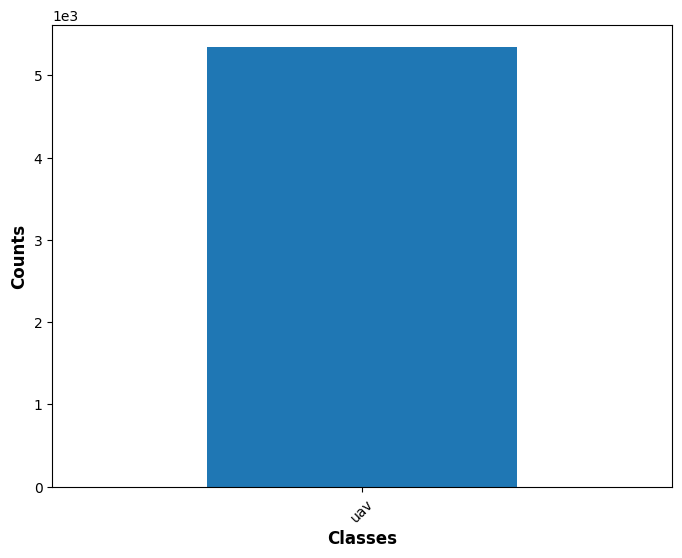

In [91]:
fig = plt.figure(figsize=(8, 6))
ax = df['class_name'].value_counts().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Classes", weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
None
fig.savefig(save_dir+'/dut_class_counts.png', bbox_inches = 'tight')

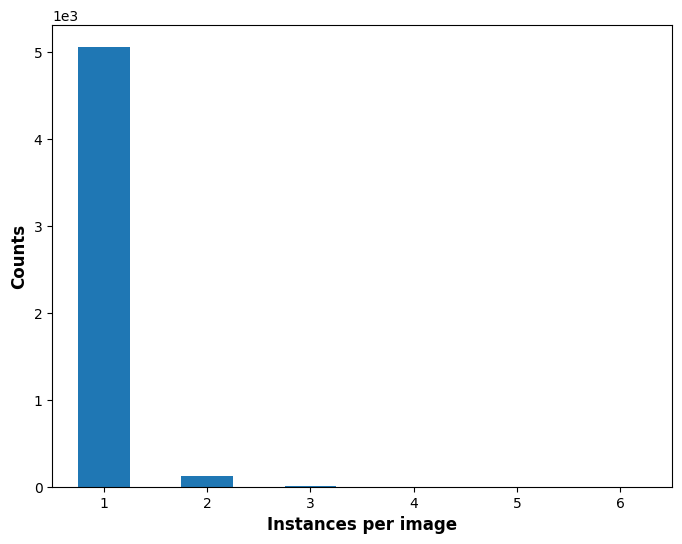

In [95]:
fig = plt.figure(figsize=(8, 6))
ax = df.groupby(by=['img'])['img'].count().value_counts().sort_index().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Instances per image", weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
None
fig.savefig(save_dir+'/dut_instances_count.png', bbox_inches = 'tight')

In [103]:
df['bbox_area'] = (df['wn']*df['img_w'])*(df['hn']*df['img_h'])
bin_edges = [0, 16**2, 32**2, 96**2, float('inf')]
bin_labels = ['tiny', 'small', 'medium', 'large']
df['bbox_size_category'] = pd.cut(df['bbox_area'], bins=bin_edges, labels=bin_labels, right=False)

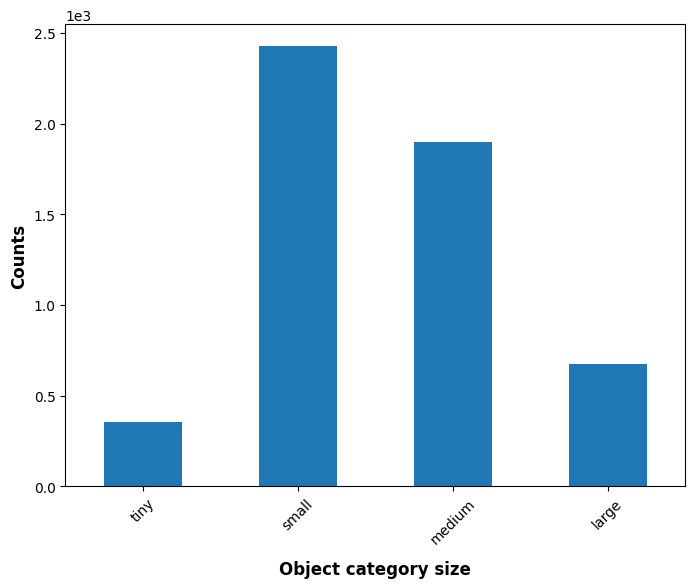

In [104]:
fig = plt.figure(figsize=(8, 6))
ax = df['bbox_size_category'].value_counts().sort_index().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Object category size", weight='bold', size=12, labelpad=10)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
None
fig.savefig(save_dir+'/dut_objsz_counts.png', bbox_inches = 'tight')

In [105]:
# TAKE INTO ACCOUNT THAT IMAGE IS UHD, THUS OBJECTS HAVE MORE PIXELS

In [106]:
df['bbox_area'] = (df['wn']*df['img_w'])*(df['hn']*df['img_h'])
bin_edges = [i * (df['img_w'].mean()*df['img_h'].mean())/(640*480) for i in bin_edges]
bin_labels = ['tiny', 'small', 'medium', 'large']
df['bbox_size_category_hd'] = pd.cut(df['bbox_area'], bins=bin_edges, labels=bin_labels, right=False)

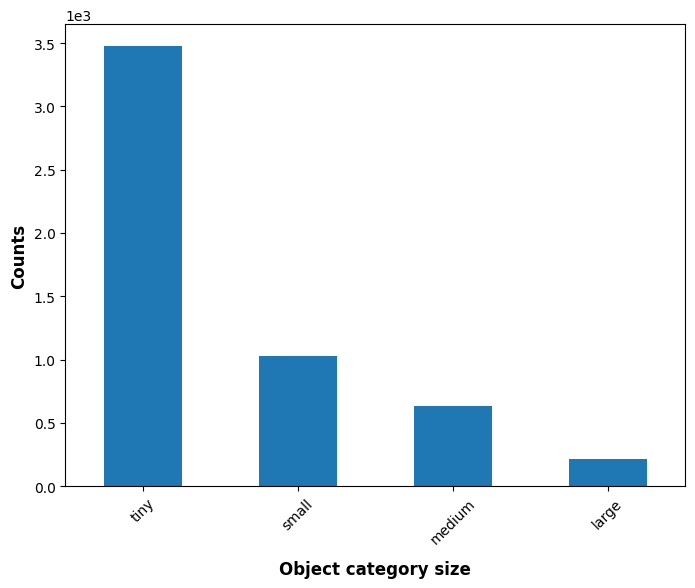

In [107]:
fig = plt.figure(figsize=(8, 6))
ax = df['bbox_size_category_hd'].value_counts().sort_index().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Object category size", weight='bold', size=12, labelpad=10)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
None
fig.savefig(save_dir+'/dut_objszhd_counts.png', bbox_inches = 'tight')